## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import norm, lognorm

In [2]:
print("Yfinance version: " , yf.__version__)

Yfinance version:  0.2.37


In [3]:
# Set default parameters for plt.title()
plt.rcParams['axes.titlepad'] = 12  # Set padding around the title
plt.rcParams['axes.titleweight'] = 'normal'  # Set title font size
plt.rcParams['axes.titlesize'] = 9  # Set title font size

## Fetch cotation data

In [4]:
def fetch_stock_data(tickers, start_date, end_date, interval):
    data = yf.download(tickers, start=start_date, end=end_date, interval=interval)
    return data

In [5]:
# select tickers
tickers = ["BRK-B", "IAU"]

# date format YYYY-MM-DD
start_date = "2010-01-01"
end_date = "2024-02-01"

# time interval to take the cotations, in this case monthly
interval= "1d"

stock_data = fetch_stock_data(tickers, start_date, end_date, interval)

display(stock_data)

[*********************100%%**********************]  2 of 2 completed


Price        Adj Close                  Close                   High  \
Ticker           BRK-B        IAU       BRK-B        IAU       BRK-B   
Date                                                                   
2010-01-04   66.220001  21.978001   66.220001  21.978001   66.500000   
2010-01-05   66.540001  21.954000   66.540001  21.954000   66.589996   
2010-01-06   66.199997  22.326000   66.199997  22.326000   66.500000   
2010-01-07   66.459999  22.181999   66.459999  22.181999   66.510002   
2010-01-08   66.440002  22.290001   66.440002  22.290001   66.480003   
...                ...        ...         ...        ...         ...   
2024-01-25  380.850006  38.230000  380.850006  38.230000  380.989990   
2024-01-26  385.399994  38.180000  385.399994  38.180000  385.730011   
2024-01-29  383.179993  38.459999  383.179993  38.459999  385.700012   
2024-01-30  387.149994  38.509998  387.149994  38.509998  387.640015   
2024-01-31  383.739990  38.490002  383.739990  38.490002  387.920013   

Price                         Low                   Open              Volume  \
Ticker            IAU       BRK-B        IAU       BRK-B        IAU    BRK-B   
Date                                                                           
2010-01-04  22.038000   65.919998  21.882000   66.000000  21.978001  1575000   
2010-01-05  22.084000   66.150002  21.870001   66.389999  21.988001  1310000   
2010-01-06  22.368000   66.199997  22.110001   66.500000  22.156000  1760000   
2010-01-07  22.264000   66.139999  22.152000   66.199997  22.230000  1505000   
2010-01-08  22.326000   66.300003  22.077999   66.480003  22.306000  1500000   
...               ...         ...        ...         ...        ...      ...   
2024-01-25  38.320000  377.890015  38.080002  379.239990  38.270000  4055800   
2024-01-26  38.270000  380.000000  38.139999  381.049988  38.250000  3621400   
2024-01-29  38.509998  379.170013  38.240002  385.489990  38.459999  3797400   
2024-01-30  38.770000  380.079987  38.389999  383.239990  38.740002  3090900   
2024-01-31  38.900002  383.549988  38.419998  386.529999  38.669998  3856400   

Price                
Ticker          IAU  
Date                 
2010-01-04  1185000  
2010-01-05   936000  
2010-01-06  1091000  
2010-01-07   811500  
2010-01-08   737000  
...             ...  
2024-01-25  4637800  
2024-01-26  3288100  
2024-01-29  3503900  
2024-01-30  4125600  
2024-01-31  9428800  

[3543 rows x 12 columns]

In [6]:
# select only the closing price
df_close = stock_data.Close.copy()
df_close.info()
df_close

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3543 entries, 2010-01-04 to 2024-01-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BRK-B   3543 non-null   float64
 1   IAU     3543 non-null   float64
dtypes: float64(2)
memory usage: 83.0 KB


Ticker,BRK-B,IAU
Date,,
2010-01-04,66.220001,21.978001
2010-01-05,66.540001,21.954000
2010-01-06,66.199997,22.326000
2010-01-07,66.459999,22.181999
2010-01-08,66.440002,22.290001
...,...,...
2024-01-25,380.850006,38.230000
2024-01-26,385.399994,38.180000
2024-01-29,383.179993,38.459999


## Calculate returns

In [7]:
# find the monthly return and drop the rows with null values.
# returns_mom = df_close.copy().pct_change().dropna()

# display(returns_mom.describe())
# returns_mom.head(3)

### Daily returns

In [8]:
returns_daily = df_close.copy().pct_change(periods=252).dropna()

display(returns_daily.describe())
returns_daily.head(3)

Ticker,BRK-B,IAU
count,3291.000000,3291.000000
mean,0.128868,0.043846
std,0.152682,0.145390
min,-0.203433,-0.291838
25%,0.008477,-0.056248
50%,0.127251,0.021489
75%,0.227862,0.146040
max,0.708833,0.542952


Ticker,BRK-B,IAU
Date,,
2011-01-03,0.214286,0.257621
2011-01-04,0.204839,0.229844
2011-01-05,0.222206,0.205769


## Fit distribution model - Returns

In [9]:
def calculate_return_params(key):
    sigma, loc, scale = lognorm.fit(returns_daily[key] + 1.0)    
    return (sigma, loc, scale)

In [10]:
# Defining return dict to receive the fitting parameters from distributions
params = ("sigma", "loc", "scale")
return_fitting_params_lognormal = { key: dict( zip( params, calculate_return_params(key)) ) for key in tickers }

In [11]:
return_fitting_params_lognormal

{'BRK-B': {'sigma': 0.16854503683615626,
  'loc': 0.22427509963917003,
  'scale': 0.8918676383381079},
 'IAU': {'sigma': 0.13086793803684144,
  'loc': -0.06396555172122623,
  'scale': 1.0983713164107627}}

## Return plots

### Normal:

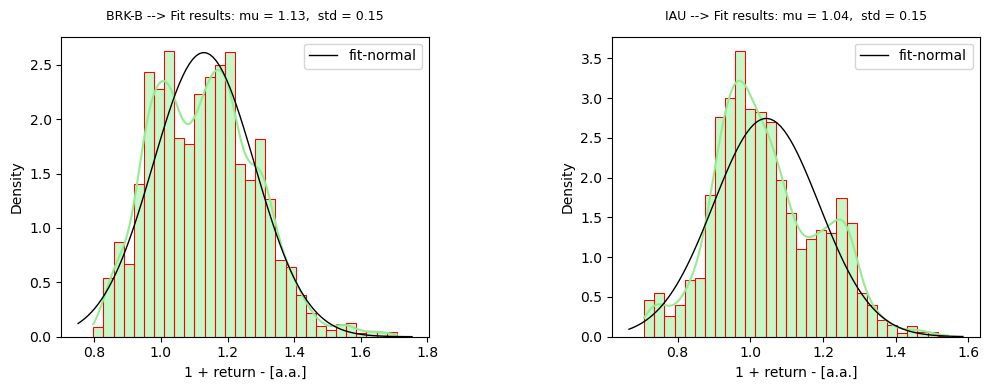

In [12]:
# Plot the histogram of the returns_daily along with the fitted Gaussian distribution
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.subplot(1, 2, 1)
# Fit a Gaussian distribution to the returns_daily
mu, std = norm.fit(returns_daily[tickers[0]] + 1.0)
sns.histplot(data= returns_daily[tickers[0]] + 1.0, bins=30, stat="density", kde=True, color='lightgreen', edgecolor='red')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', label="fit-normal", linewidth=1)
plt.title(f"{tickers[0]} --> Fit results: mu = %.2f,  std = %.2f" % (mu, std))
plt.ylabel("Density")
plt.xlabel("1 + return - [a.a.]")
plt.legend()

plt.subplot(1, 2, 2)
# Fit a Gaussian distribution to the returns_daily
mu, std = norm.fit(returns_daily[tickers[1]] + 1.0)
sns.histplot(data= returns_daily[tickers[1]] + 1.0, bins=30, stat="density", kde=True, color='lightgreen', edgecolor='red')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', label="fit-normal", linewidth=1)
plt.title(f"{tickers[1]} --> Fit results: mu = %.2f,  std = %.2f" % (mu, std))
plt.ylabel("Density")
plt.xlabel("1 + return - [a.a.]")
plt.legend()

fig.tight_layout()
fig.subplots_adjust(wspace=0.5)
plt.show()

### Lognormal:

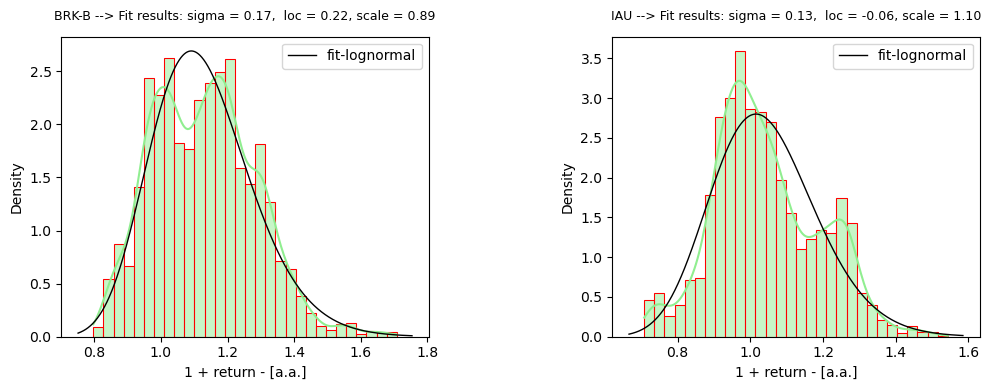

In [13]:
# Plot the histogram of the returns_daily along with the fitted Gaussian distribution
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))


# Fit a Gaussian distribution to the returns_daily
plt.subplot(1, 2, 1)
data = returns_daily[tickers[0]] + 1.0
sigma, loc, scale = lognorm.fit(data)
sns.histplot(data= data, bins=30, stat="density", kde=True, color='lightgreen', edgecolor='red')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = lognorm.pdf(x, sigma, loc= loc, scale= scale)

plt.plot(x, p, 'k', label="fit-lognormal", linewidth=1)
plt.title(f"{tickers[0]} --> Fit results: sigma = %.2f,  loc = %.2f, scale = %.2f" % (sigma, loc, scale))
plt.ylabel("Density")
plt.xlabel("1 + return - [a.a.]")
plt.legend()


# Fit a Gaussian distribution to the returns_daily
plt.subplot(1, 2, 2)
data = returns_daily[tickers[1]] + 1.0
sigma, loc, scale = lognorm.fit(data)
sns.histplot(data= data, bins=30, stat="density", kde=True, color='lightgreen', edgecolor='red')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = lognorm.pdf(x, sigma, loc= loc, scale= scale)

plt.plot(x, p, 'k', label="fit-lognormal", linewidth=1)
plt.title(f"{tickers[1]} --> Fit results: sigma = %.2f,  loc = %.2f, scale = %.2f" % (sigma, loc, scale))
plt.ylabel("Density")
plt.xlabel("1 + return - [a.a.]")
plt.legend()

fig.tight_layout()
fig.subplots_adjust(wspace=0.5)
plt.show()

## Calculate risks

### Year-over-year (DoD)

In [14]:
# find the 
risks_yoy = (df_close
             .copy()
             .pct_change(periods=1)
             .dropna()
             .rolling(window=252)
             .var()
             .dropna()
             .apply(lambda x: np.sqrt(252 * x))
)

display(risks_yoy.describe())
risks_yoy

Ticker,BRK-B,IAU
count,3291.000000,3291.000000
mean,0.187933,0.152009
std,0.059100,0.033373
min,0.107715,0.090822
25%,0.142990,0.134194
50%,0.173900,0.152099
75%,0.211625,0.168835
max,0.350161,0.222172


Ticker,BRK-B,IAU
Date,,
2011-01-03,0.230494,0.164447
2011-01-04,0.230492,0.166194
2011-01-05,0.230566,0.165453
2011-01-06,0.230670,0.165355
2011-01-07,0.230831,0.165320
...,...,...
2024-01-25,0.134383,0.131483
2024-01-26,0.134837,0.131396
2024-01-29,0.134944,0.131233


## Fit distribution model - Risks

In [15]:
def calculate_risk_params(key):
    sigma, loc, scale = lognorm.fit(risks_yoy[key])
    return (sigma, loc, scale)

In [16]:
# Defining risk dict to receive the fitting parameters from distribuions
risk_fitting_params_lognormal = { key: dict( zip( params, calculate_risk_params(key)) ) for key in tickers }

In [17]:
risk_fitting_params_lognormal

{'BRK-B': {'sigma': 0.6119949610121653,
  'loc': 0.09382935748134587,
  'scale': 0.07831963536101066},
 'IAU': {'sigma': 0.06490435161839886,
  'loc': -0.3621119237577112,
  'scale': 0.5130399144537628}}

## Risk plots

### Normal:

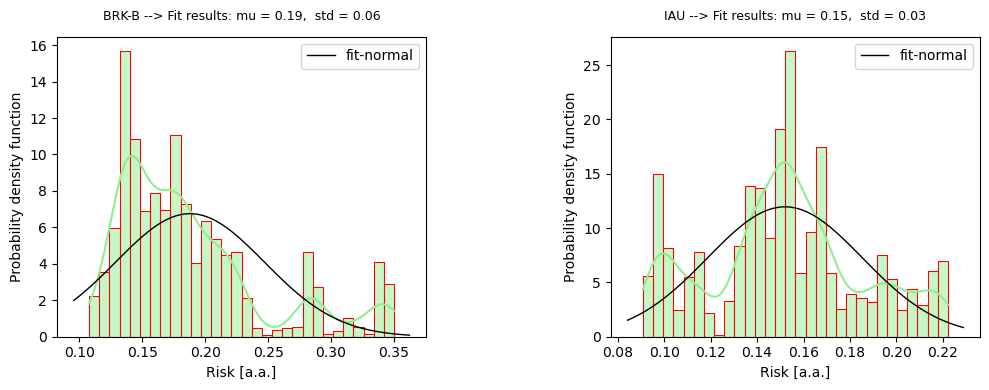

In [18]:
# Plot the histogram of the returns_daily along with the fitted Gaussian distribution
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.subplot(1, 2, 1)
# Fit a Gaussian distribution to the returns_daily
mu, std = norm.fit(risks_yoy[tickers[0]])
sns.histplot(data= risks_yoy[tickers[0]], bins=30, stat="density", kde=True, color='lightgreen', edgecolor='red')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', label="fit-normal", linewidth=1)
plt.title(f"{tickers[0]} --> Fit results: mu = %.2f,  std = %.2f" % (mu, std))
plt.ylabel("Probability density function")
plt.xlabel("Risk [a.a.]")
plt.legend()

plt.subplot(1, 2, 2)
# Fit a Gaussian distribution to the returns_daily
mu, std = norm.fit(risks_yoy[tickers[1]])
sns.histplot(data= risks_yoy[tickers[1]], bins=30, stat="density", kde=True, color='lightgreen', edgecolor='red')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', label="fit-normal", linewidth=1)
plt.title(f"{tickers[1]} --> Fit results: mu = %.2f,  std = %.2f" % (mu, std))
plt.ylabel("Probability density function")
plt.xlabel("Risk [a.a.]")
plt.legend()

fig.tight_layout()
fig.subplots_adjust(wspace=0.5)
plt.show()

### Lognormal:

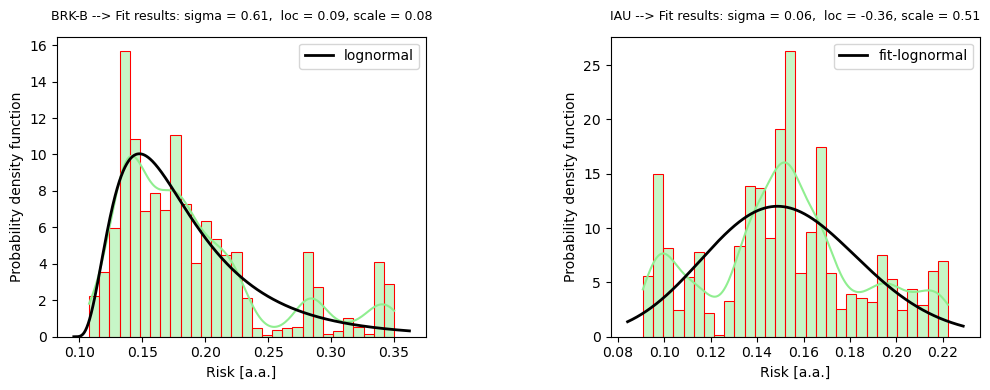

In [19]:
# Plot the histogram of the returns_daily along with the fitted Gaussian distribution
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.subplot(1, 2, 1)
# Fit a Lognormal distribution to the returns_daily (actually, the pricing ratio Pn+12/Pn)
sigma, loc, scale = lognorm.fit(risks_yoy[tickers[0]])

sns.histplot(data= risks_yoy[tickers[0]], bins=30, stat="density", kde=True, color='lightgreen', edgecolor='red')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
pdf = lognorm.pdf(x, sigma, loc= loc, scale= scale)

plt.plot(x, pdf, 'k', label="lognormal", linewidth=2)
plt.title(f"{tickers[0]} --> Fit results: sigma = %.2f,  loc = %.2f, scale = %.2f" % (sigma, loc, scale))
plt.ylabel("Probability density function")
plt.xlabel("Risk [a.a.]")
plt.legend()

plt.subplot(1, 2, 2)
# Fit a Lognormal distribution to the returns_daily (actually, the pricing ratio Pn+12/Pn)
sigma, loc, scale = lognorm.fit(risks_yoy[tickers[1]])

sns.histplot(data= risks_yoy[tickers[1]], bins=30, stat="density", kde=True, color='lightgreen', edgecolor='red')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
pdf = lognorm.pdf(x, sigma, loc= loc, scale= scale)

plt.plot(x, pdf, 'k', label="fit-lognormal", linewidth=2)
plt.title(f"{tickers[1]} --> Fit results: sigma = %.2f,  loc = %.2f, scale = %.2f" % (sigma, loc, scale))
plt.ylabel("Probability density function")
plt.xlabel("Risk [a.a.]")
plt.legend()

fig.tight_layout()
fig.subplots_adjust(wspace=0.5)
plt.show()

## Best resulting models

### Returns:

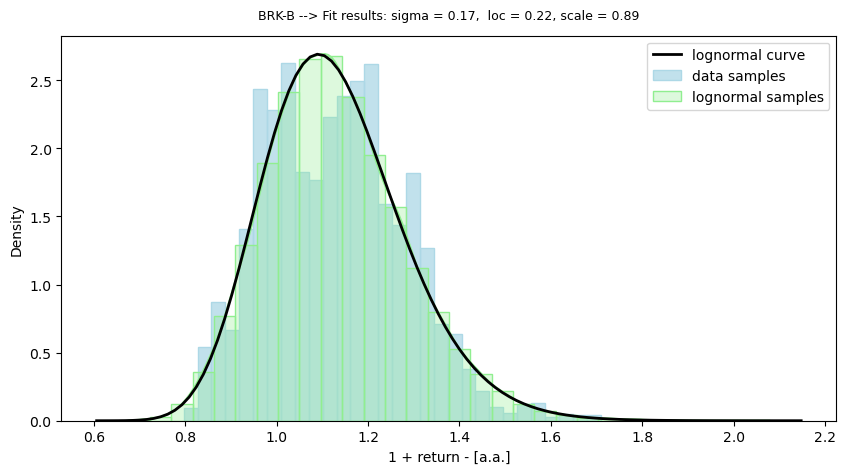

In [20]:
# Find the best parameters when fitting the model to the data
data = returns_daily[tickers[0]] + 1.0
sigma, loc, scale = lognorm.fit(data)

# Generate samples based on the parameters find previously
num_samples = 100_000
samples = lognorm.rvs(sigma, loc=loc, scale=scale, size=num_samples)

# Plot the histogram of the generated samples
plt.figure(figsize=(10,5))
sns.histplot(data, bins=30, stat="density", color='lightblue', edgecolor='lightblue', label="data samples")
sns.histplot(samples, bins=30, stat="density", kde=True, color='lightgreen', edgecolor='lightgreen', alpha=0.3, label="lognormal samples")

# Plot the PDF of the lognormal distribution for comparison
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
pdf = lognorm.pdf(x, sigma, loc= loc, scale= scale)

plt.plot(x, pdf, 'k', linewidth=2, label="lognormal curve")
plt.title(f"{tickers[0]} --> Fit results: sigma = %.2f,  loc = %.2f, scale = %.2f" % (sigma, loc, scale))
plt.ylabel("Density")
plt.xlabel("1 + return - [a.a.]")
plt.legend()
plt.show()

## Generate samples from distributions models

In [21]:
# Number of samples
num_samples = 1_000

In [22]:
def calculate_return_samples(ticker, num_samples=100_000):
    sigma   = return_fitting_params_lognormal[ticker]["sigma"]
    loc     = return_fitting_params_lognormal[ticker]["loc"]
    scale   = return_fitting_params_lognormal[ticker]["scale"]
    samples = lognorm.rvs(sigma, loc=loc, scale=scale, size=num_samples)  
    return samples

def calculate_risk_samples(ticker, num_samples=100_000):
    sigma   = risk_fitting_params_lognormal[ticker]["sigma"]
    loc     = risk_fitting_params_lognormal[ticker]["loc"]
    scale   = risk_fitting_params_lognormal[ticker]["scale"]
    samples = lognorm.rvs(sigma, loc=loc, scale=scale, size=num_samples)  
    return samples

In [23]:
# Defining return dict to receive the samples from distributions models builted with their respective parameters
return_samples_lognormal = { ticker: calculate_return_samples(ticker, num_samples) for ticker in tickers }
risk_samples_lognormal   = { ticker:  calculate_risk_samples(ticker, num_samples)  for ticker in tickers }

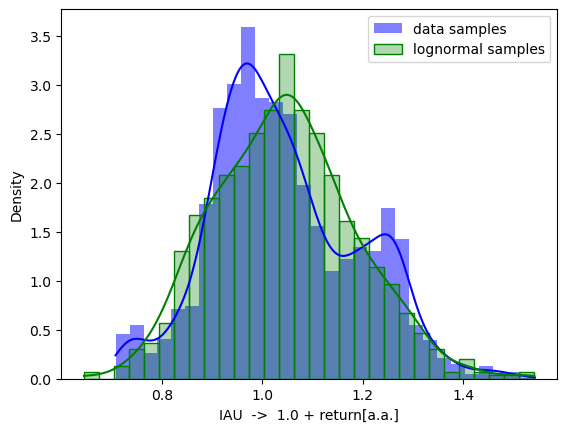

In [24]:
ticker = tickers[1]
sns.histplot(returns_daily[ticker] + 1.0, bins=30, stat="density", kde=True, color='blue', edgecolor=None, label="data samples")
sns.histplot(return_samples_lognormal[ticker], bins=30, stat="density", kde=True, color='green', edgecolor='green', alpha=0.3, label="lognormal samples")
plt.xlabel(f"{ticker}  ->  1.0 + return[a.a.]")
plt.legend()
plt.show()

## Monte carlo simulation

### Equations:
<br>

- **Portfolio Return**:
<br>
$$ R_P = {\omega}^T \cdot R $$
<br>
with $R_P$ being the return of the portfolio, $\omega$ the weights and $R$ the returns of the assets. Each one are given by:
<br><br>

<table>
  <tr>
    <td>
      $$
        \omega = \begin{bmatrix}
                {\omega}_A \\
                {\omega}_B \\
                {\omega}_C \\
        \end{bmatrix},
      $$
    </td>
    <td>
      and
    </td>
    <td>
    $$
        R = \begin{bmatrix}
                R_A \\
                R_B \\
                R_C \\
        \end{bmatrix}.
    $$
    </td>
  </tr>
</table>

<br>

- **Portfolio Risk**: 
<br>
$$ {{\sigma}^2_P} = {\omega}^T \cdot \Sigma \cdot \omega $$
<br>
in wich ${{\sigma}^2_P}$ is the variance of the portfolio and $\Sigma$ is the covariance matrix of the assets. The covariance matrix is given by:
<br>
<br>
$$ \Sigma = \begin{bmatrix}
                {{\sigma}^2_A} & cov(A,B) & cov(A,C) \\
                cov(A,B) & {{\sigma}^2_B} & cov(B,C) \\
                cov(A,C) & cov(B,C) & {{\sigma}^2_C} \\
            \end{bmatrix}.
$$
<br>




#### Generate asset weights

In [25]:
# Matrix of the weights
w1  = np.random.uniform(low=0.0, high=1.0, size=num_samples).reshape((num_samples, 1))
w2  = 1.0 - w1

#### Portfolio Return

In [26]:
# Matrix of the returns
R1 = return_samples_lognormal[tickers[0]].reshape((1, num_samples)) - 1.0
R2 = return_samples_lognormal[tickers[1]].reshape((1, num_samples)) - 1.0

portfolio_return = np.dot(w1, R1) + np.dot(w2, R2)

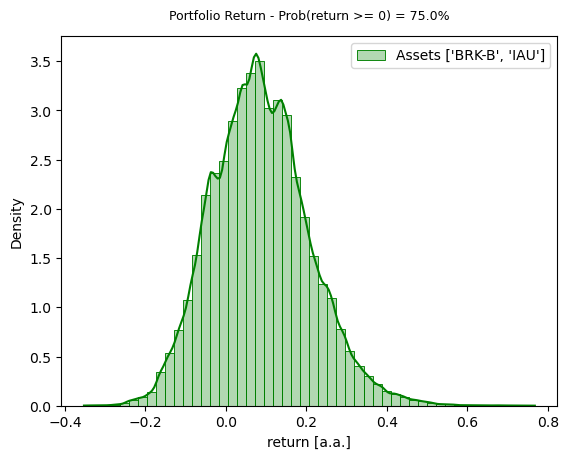

In [38]:
data = portfolio_return.reshape(-1)
threshold = 0
return_threshold = np.count_nonzero(data > threshold) / np.max(data.shape)

sns.histplot(data, bins=50, stat="density", kde=True, color='green', edgecolor='green', alpha=0.3, label=f"Assets {tickers}")
plt.title(f"Portfolio Return - Prob(return >= {threshold}) = {int(100 * return_threshold)}.0%")
plt.xlabel("return [a.a.]")
plt.legend()
plt.show()